In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

# Customer Segmentation

In [4]:
df = pd.read_csv('DataCoSupplyChain.csv', encoding='unicode-escape')
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [6]:
df.shape

(180519, 53)

In [7]:
df1 = df.copy(deep = True)

Understanding customer needs and targeting specific clusters of customers based on their need is one way for a supply chain company to increase number of customers and also to gain more profits.Since,purchase history of customers is already avaialble in the dataset, it can use RFM analysis for customer segmention. Even though there are so many different methods for customer segmentation,RFM analysis is being used because it utilizes numerical values to show Customer recency,frequency and monetary values and also the output results are easy to interpret.

In [8]:
#Calculating total price for which each order
df1['TotalPrice'] = df1['Order Item Quantity'] * df1['Order Item Total']

In [9]:
df1['order date (DateOrders)'].max() # Calculating when the last order come to check recency

'9/9/2017 9:50'

In [16]:
import datetime as dt

In [18]:
#Present date was set to next day of the last order. i.e,2018-02-01
present = dt.datetime(2018,2,1)
df1['order date (DateOrders)'] = pd.to_datetime(df1['order date (DateOrders)'])

In [19]:
# Grouping all values into new data frame named customer segmentation
Customer_seg = df1.groupby('Order Customer Id').agg({'order date (DateOrders)': lambda x: (present - x.max()).days, 'Order Id': lambda x: len(x), 'TotalPrice': lambda x: x.sum()})
#Changing order dates to int format
Customer_seg['order date (DateOrders)'] = Customer_seg['order date (DateOrders)'].astype(int)
# Renaming columns as R_Value,F_Value,M_Value
Customer_seg.rename(columns={'order date (DateOrders)': 'R_Value', 
                         'Order Id': 'F_Value', 
                         'TotalPrice': 'M_Value'}, inplace=True)
Customer_seg.head()

,R_Value,F_Value,M_Value
Order Customer Id,,,
1,792,1,2362.250061
2,136,10,2842.700073
3,229,18,6143.760057
4,380,14,4370.629991
5,457,7,2993.790032


R_Value(Recency) indicates how much time elapsed since a customer last order.

F_Value(Frequency) indicates how many times a customer ordered.

M_Value(Monetary value) tells us how much a customer has spent purchasing items.

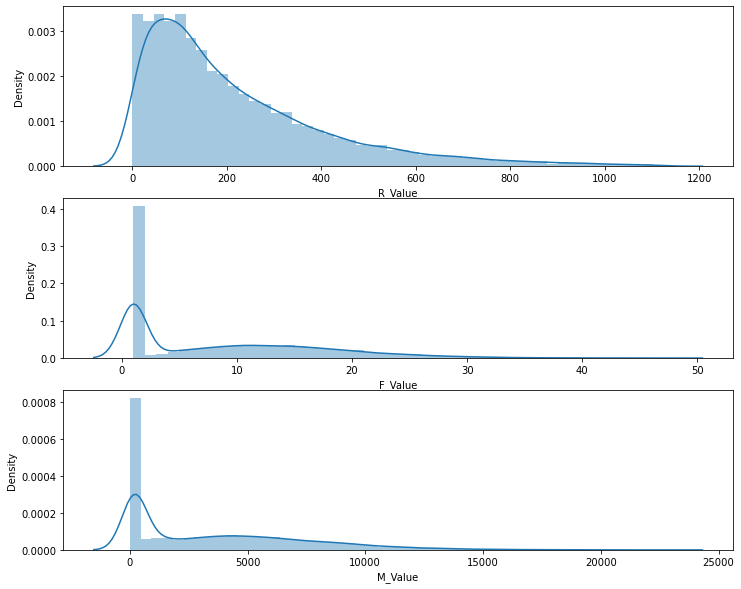

In [20]:
plt.figure(figsize=(12,10)) # Figure size
plt.subplot(3, 1, 1)
sns.distplot(Customer_seg['R_Value'])# Plot distribution of R_Value
plt.subplot(3, 1, 2) 
sns.distplot(Customer_seg['F_Value'])# Plot distribution of F_Value
plt.subplot(3, 1, 3)
sns.distplot(Customer_seg['M_Value'])# Plot distribution of M_Value
plt.show()

In [21]:
quantiles = Customer_seg.quantile(q=[0.25,0.5,0.75]) #Dividing RFM data into four quartiles
quantiles = quantiles.to_dict() 

The total data is divided into 4 quantiles. The R_Value should be low because it indicates recent customer activity and 
F_value, M_Value should be high since they indicate frequency and total value of purchase. 
Function is defined to indicate quantiles as numerical values.

In [22]:
# R_Score should be minimum so 1st quantile is set as 1.
def R_Score(a,b,c):
    if a <= c[b][0.25]:
        return 1
    elif a <= c[b][0.50]:
        return 2
    elif a <= c[b][0.75]: 
        return 3
    else:
        return 4
# The higher the F_Score,M_Score the better so 1st quantile is set as 4.    
def FM_Score(x,y,z):
    if x <= z[y][0.25]:
        return 4
    elif x <= z[y][0.50]:
        return 3
    elif x <= z[y][0.75]: 
        return 2
    else:
        return 1

In [23]:
# New column for R_Score to indicate numerical score between 1 to 4.
Customer_seg['R_Score'] = Customer_seg['R_Value'].apply(R_Score, args=('R_Value',quantiles))
# New column for F_Score to indicate numerical score between 1 to 4.
Customer_seg['F_Score'] = Customer_seg['F_Value'].apply(FM_Score, args=('F_Value',quantiles))
# New column for M_Score to indicate numerical score between 1 to 4.
Customer_seg['M_Score'] = Customer_seg['M_Value'].apply(FM_Score, args=('M_Value',quantiles))
Customer_seg.head()

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score
Order Customer Id,,,,,,
1,792,1,2362.250061,4,4,3
2,136,10,2842.700073,2,2,2
3,229,18,6143.760057,3,1,1
4,380,14,4370.629991,4,2,2
5,457,7,2993.790032,4,3,2


The individual scores of R,F,M are known.A column for combined RFM score is created.

In [27]:
#Adding R,F,M Scores to one new column
Customer_seg['RFM_Score'] = Customer_seg.R_Score.astype(str)+ Customer_seg.F_Score.astype(str)+Customer_seg.M_Score.astype(str)
Customer_seg.head()

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score
Order Customer Id,,,,,,,
1,792,1,2362.250061,4,4,3,443
2,136,10,2842.700073,2,2,2,222
3,229,18,6143.760057,3,1,1,311
4,380,14,4370.629991,4,2,2,422
5,457,7,2993.790032,4,3,2,432


How many different customer segments are there in total can be found using .unique() and len method.

In [28]:
count=Customer_seg['RFM_Score'].unique()
print(count)# Printing all Unique values
len(count)# Total count

['443' '222' '311' '422' '432' '421' '211' '322' '434' '212' '411' '331'
 '412' '433' '321' '423' '333' '312' '221' '223' '332' '233' '232' '323'
 '444' '431' '343' '243' '344' '334' '244' '143' '144']


33

It can be seen that there are 33 different customer segments. 
To make it easier for segmentation individual R,F,M scores are added together

In [29]:
# Calculate RFM_Score
Customer_seg['RFM_Total_Score'] = Customer_seg[['R_Score','F_Score','M_Score']].sum(axis=1)
Customer_seg['RFM_Total_Score'].unique()

array([11,  6,  5,  8,  9,  7,  4, 10, 12], dtype=int64)

There are 9 values in total for customer segmentation.Appropriate names were assigned for each value seperately.

In [31]:
# Define rfm_level function
def RFM_Total_Score(df): 
    
    if (df['RFM_Total_Score'] >= 11):# For RFM score with values 11,12
        return 'Champions' 
    elif (df['RFM_Total_Score'] == 10):# For RFM score with value 10
        return 'Loyal Customers' 
    elif (df['RFM_Total_Score'] == 9): # For RFM score with value 9
        return 'Recent Customers'
    elif (df['RFM_Total_Score'] == 8): # For RFM score with value 8
         return 'Promising'
    elif (df['RFM_Total_Score'] == 7): # For RFM score with value 7
        return 'Customers Needing Attention'
    elif (df['RFM_Total_Score'] == 6): # For RFM score with value 6
        return 'Cant lose them'
    elif (df['RFM_Total_Score'] == 5): # For RFM score with value 5
        return 'At Risk'
    else:                               # For RFM score with value less than 5
        
        return 'Lost'
# Create a new variable RFM_Level
Customer_seg['Customer_Segmentation'] =Customer_seg.apply(RFM_Total_Score, axis=1)
# Print the header with top 5 rows to the console
Customer_seg.head()

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score,RFM_Total_Score,Customer_Segmentation
Order Customer Id,,,,,,,,,
1,792,1,2362.250061,4,4,3,443,11,Champions
2,136,10,2842.700073,2,2,2,222,6,Cant lose them
3,229,18,6143.760057,3,1,1,311,5,At Risk
4,380,14,4370.629991,4,2,2,422,8,Promising
5,457,7,2993.790032,4,3,2,432,9,Recent Customers


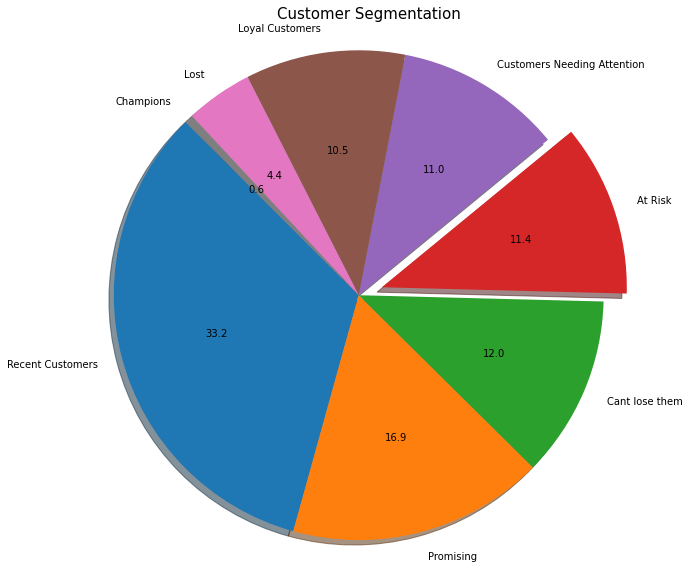

In [32]:
# Calculate average values for each RFM_Level, and return a size of each segment 
Customer_seg['Customer_Segmentation'].value_counts().plot.pie(figsize=(10,10),
                                        startangle=135, explode=(0,0,0,0.1,0,0,0,0),autopct='%.1f',shadow=True)
plt.title("Customer Segmentation",size=15)
plt.ylabel(" ")
plt.axis('equal') 
plt.show()

Since total customers are divided into 9 segments it can be seen that, 
11.4% customers are at risk of losing them as customers and 11% customers needs attention else even they will be lost eventually.It can be seen that 4.4% of customers are already lost.

Our Top 10 Churned best customers who has not purchased anything in a while

In [33]:
churned=Customer_seg[(Customer_seg['RFM_Score']=='411')].sort_values('M_Value', ascending=False).head(10)
churned

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score,RFM_Total_Score,Customer_Segmentation
Order Customer Id,,,,,,,,,
11065,309,41,18641.300091,4,1,1,411,6,Cant lose them
6285,332,37,18287.010097,4,1,1,411,6,Cant lose them
7892,392,29,17620.470196,4,1,1,411,6,Cant lose them
2893,312,24,17536.609842,4,1,1,411,6,Cant lose them
4181,425,29,17333.960094,4,1,1,411,6,Cant lose them
4781,502,31,17048.380088,4,1,1,411,6,Cant lose them
9271,344,35,17044.910217,4,1,1,411,6,Cant lose them
4659,417,27,16973.060024,4,1,1,411,6,Cant lose them
1695,326,33,16916.020176,4,1,1,411,6,Cant lose them


These customers used to place orders with huge amounts very frequently but they did not place orders from almost a year which means they are purchasing from other companies. These groups of people should be targeted with offers to gain them back.

Top 10 new best customers who place costly orders often.

In [35]:
#The R_Score should be low and F_Score, M_Score should be as high as possible
Customer_seg[(Customer_seg['RFM_Score']=='144')|
                             (Customer_seg['RFM_Score']=='143')].sort_values('M_Value', ascending=False).head(10)

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score,RFM_Total_Score,Customer_Segmentation
Order Customer Id,,,,,,,,,
18101,38,1,1500.0,1,4,3,143,8,Promising
18083,39,1,1500.0,1,4,3,143,8,Promising
18047,39,1,1500.0,1,4,3,143,8,Promising
18065,39,1,1500.0,1,4,3,143,8,Promising
18119,38,1,1500.0,1,4,3,143,8,Promising
18046,39,1,1485.0,1,4,3,143,8,Promising
18100,38,1,1485.0,1,4,3,143,8,Promising
18118,38,1,1485.0,1,4,3,143,8,Promising
18064,39,1,1485.0,1,4,3,143,8,Promising


The above customers has the potential to become best customers this people should be targeted to convert them into 
loyal customers.All these different segment of customers should be targeted with different tailored advertisments and 
rewards for increased profits and more responsiveness from customers.
